# Inferring Grammars from X86 Binaries

Stripped Binaries are binaries that does not include debugging symbols during program execution. This can be produced by including `-s` flag when compiling the program with `gcc`.
When considering stripped binaries, we would understand that our above implementation cannot directly be used to obtain an input grammar from such binaries since they do not contain debugging information. 

One thing to consider is that stripped binaries only contains sets of `assembly instructions` which are usually executed sequentially at runtime. With this idea, we can observe these sets of instrutions and then infer some useful program informations which would be useful to produce meaningful input grammar.

* Evaluation starts [here](#Evaluation)
  * The evaluation on specific subjects starts [here](#Subjects)
    * [Calculator](#Calculator)
    * [CSV](#CSV)
    * [Url](#Url-parser)
    * [JSON](#JSON)
    * [Lisp](#Lisp)
    * [TinyC](#TinyC)

## Install Prerequisites

This notebook relies on two main packages;
* `GDB`
* `FuzzingBook` library

Firstly, we need check if `GDB` is installed by run the cell below

In [1]:
!which -a gdb

/usr/bin/gdb


and if not we would need to install it. if `GDB` is not installed, you will need to installed `GDB` on your computer. For example, on linux you can run the command below from terminal;
```
sudo apt-get install gdb
```

Next, we need to install the FuzzingBook library

In [2]:
!pip install fuzzingbook

In [3]:
import fuzzingbook

## X86 Instruction

An X86 instruction is typically made up of a line address, an instruction type which represents what type of action the instruction is meant to carry out and also a register where the action is operation on.

Below is an example of an instruction that moves a value from one register to another;

`0x555555554892:      mov    %rsp,%rbp` where `0x555555554892` is the current line address, `mov` is the type of instruction that should be carried out and lastly `%rsp`,`%rbp` which represents the registers where the `mov` operation should be carried out. In this case, `mov` the content in register `rsp` to `rbp`.

In [4]:
from enum import Enum

### Instruction Type

We represent function call and return in an instruction set as variables. for example, an instruction type can be `call` which represent a function call.

In [5]:
CALL = 'callq'
RETURN = 'retq'

### X86 Registers

We represent X86 registers as an array of string values

In [6]:
ARG_REGISTERS = ['rdi', 'rdx', 'rcx', 'r8', 'r9', 'rbx']
REGISTERS = ARG_REGISTERS + ['rax', 'rsp', 'rbp', 'al']

**NOTE**: Since we are working with `GDB` we cannot run our implement directly within jupyter notebook. Therefore, we save all code implementation and variables into a single script that can be executed from command line.

In [7]:
VARIABLES = '''
CALL = 'callq'
RETURN = 'retq'

ARG_REGISTERS = ['rdi', 'rdx', 'rcx', 'r8', 'r9', 'rbx']
REGISTERS = ARG_REGISTERS + ['rax', 'rsp', 'rbp', 'al']
'''

### Instruction

With the information that can be obtained from instructions set, we represents this as a class `Instruction`.

In [8]:
class Instruction:
    def __init__(self, instr):
        self.symbol_name = None
        self.pointed_address = None
        self.dest_reg = None
        self.instr_type = None
        self._parse(instr)

Firstly within the constructor of the `Instruction` class, the variable `symbol_name` is used to hold the name of a function, variable `pointed_address` is used to hold the address of a function that is about to be called, variable `dest_reg` is used to hold the name of the register where an operation has been carried out.

method `get_pointed_address()` is used to get the address of a function that is about to be called. This method is useful when we have a `call` instruction

In [9]:
class Instruction(Instruction):
    def get_pointed_address(self, inp_value):
        inp_value = inp_value.strip('%*')
        if inp_value in REGISTERS:
            pointed_address = gdb.execute('x/s $%s' % (inp_value),to_string=True)
            pointed_address = pointed_address.split(':')
            return pointed_address[0]
        return inp_value

 method `resolve_addressing_mode()` used to derive an expression that calculates an address in memory to be read/written to. For example, if we have the instruction `movl $1, -24(%rbp)`, we can resolve the address where the value of such instruction is located by computing `address = base $rbp + displacement -24)`

In [10]:
class Instruction(Instruction):
    def resolve_addressing_mode(self, instruction):
            splited_instruction = instruction.split(',')
            if len(splited_instruction) > 2:
                if instruction.startswith('%'):
                    return '$%s' % (splited_instruction[0][1:])
                else:
                    if instruction.startswith('-') or instruction.startswith('0x'):
                        displacement, base = tuple(splited_instruction[0].split('(%'))
                        index = splited_instruction[1][1:]
                        scale = splited_instruction[2].strip(')')
                        return '$%s+%s+%s*$%s' % (base, displacement, scale, index)

            src = splited_instruction[-1]
            if '(' not in src:
                if src[1:] in REGISTERS:
                    return '$%s' % src[1:]
            else:
                if src.startswith('-'):
                    displacement, rest = tuple(src.split('(%'))
                    return '$%s%s' % (rest[:-1], displacement)
                elif src.startswith('(') and src.endswith(')'):
                    return '$%s' % src[2: -1]
                else:
                    displacement, rest = tuple(src.split('(%'))
                    return '$%s+%s' % (rest[:-1], displacement)

method `_parse()` makes use of all the functions and variables defined so far. It basically splits an instruction string into parts and assign useful part of the splited instruction into the variables defined in the constructor. Also, it resolves addressing for data movement instructions. 

Data movement instructions are instructions which basically equivalent to variable assignment. Such instruction types includes `mov`, `push`, `pop`.

In [11]:
class Instruction(Instruction):
    def _parse(self, instr):
        instr_list = instr.split()
        instr_list.pop(0)

        self.current_address = instr_list[0]
        if "<" in instr_list[1]:
            instr_list.pop(1)
        self.instr_type = instr_list[1]

        if self.instr_type == CALL:
            self.pointed_address = self.get_pointed_address(instr_list[2])
            if len(instr_list) > 3:
                self.symbol_name = instr_list[-1]
        
        elif self.instr_type.startswith('mov') or self.instr_type == 'push' or \
            self.instr_type == 'pop' or self.instr_type == 'cmp':
            self.dest_reg = self.resolve_addressing_mode(instr_list[2])

### Accessing memory content of registers and address

After representing instructions as an object and defining how to resolve addressing, we need read the memory content of registers or addresses pointed by the register.

Gdb provides command for reading the content of registers or an address. General format for the command is, `x/nfu addr`. `x` to examine memory in any of several formats. `n`, `f`, and `u` are all optional parameters that specify how much memory to display and how to format it.

In this notebook, we will be using the command `x/s`, `x/a` `p/c` for reading, printing string, address and single character values respectively.

#### Reading pointed address from register

The method `read_pointed_address` is used to obtain an address pointed to by a register.

In [12]:
def read_pointed_address(reg):
    try:
        output_string = gdb.execute('x/a %s' % (reg), to_string=True)
        return split_string(output_string)
    except Exception:
        return

In [13]:
def split_string(string):
    return_str = None
    for idx, char in enumerate(string):
        if string[idx] == ':':
            return_str = string[idx + 1:]
            return_str = return_str.strip()
            break
    return return_str

#### Reading string value from register

This method is used to obtain string content of an address or register.

In [14]:
def read_as_string(reg):
    try:
        output_string1 = gdb.execute('x/s %s' % (reg), to_string=True)
        return split_string(output_string1)
    except Exception:
        return

In [15]:
read_address_string_methods = '''
def read_pointed_address(reg):
    try:
        output_string = gdb.execute('x/a %s' % (reg), to_string=True)
        return split_string(output_string)
    except Exception:
        return

def split_string(string):
    return_str = None
    for idx, char in enumerate(string):
        if string[idx] == ':':
            return_str = string[idx + 1:]
            return_str = return_str.strip()
            break
    return return_str
        
def read_as_string(reg):
    try:
        output_string1 = gdb.execute('x/s %s' % (reg), to_string=True)
        return split_string(output_string1)
    except Exception:
        return

def read_as_hex(reg):
    try:
        output_string2 = gdb.execute('x/x %s' % (reg), to_string=True)
        return split_string(output_string2)
    except Exception:
        return
'''

#### Combining both

This method `read_register_value` makes use of the above defined methods in reading the content of an address or register during debugging.

In [16]:
def read_register_value(reg, original, instr_type):
    if instr_type.endswith('movb'):
        hex_value = read_as_hex(reg)
        if hex_value:
            return extract_char(hex_value)

    if not reg:
        return None
    if reg == '$al':
        return extract_char(reg)

    val = read_as_string(reg)
    if not val or 'error' in val:
        return None
    elif val in original:
        return val
    else:
        if val[1:-1] in original:
            return val[1:-1]
        address = read_pointed_address(reg)
        str_val = read_register_value(address, original, instr_type)
        return str_val

In [17]:
read_register_value = '''
def read_register_value(reg, original, instr_type):
    if instr_type.endswith('movb'):
        hex_value = read_as_hex(reg)
        if hex_value:
            return extract_char(hex_value)

    if not reg:
        return None
    if reg == '$al':
        char_val = gdb.execute('p/c %s' % (reg), to_string=True)
        char_val = char_val.split()
        char_val = char_val[-1]
        return char_val[1:-1]

    val = read_as_string(reg)
    if not val or 'error' in val:
        return None
    elif val in original:
        return val
    else:
        if val[1:-1] in original:
            return val[1:-1]
        address = read_pointed_address(reg)
        str_val = read_register_value(address, original, instr_type)
        return str_val

def extract_char(addr):
    char_val = gdb.execute('p/c %s' % (addr), to_string=True)
    char_val = char_val.split()
    char_val = char_val[-1]
    return char_val[1:-1]
'''

In [18]:
print(read_register_value)


def read_register_value(reg, original, instr_type):
    if instr_type.endswith('movb'):
        hex_value = read_as_hex(reg)
        if hex_value:
            return extract_char(hex_value)

    if not reg:
        return None
    if reg == '$al':
        char_val = gdb.execute('p/c %s' % (reg), to_string=True)
        char_val = char_val.split()
        char_val = char_val[-1]
        return char_val[1:-1]

    val = read_as_string(reg)
    if not val or 'error' in val:
        return None
    elif val in original:
        return val
    else:
        if val[1:-1] in original:
            return val[1:-1]
        address = read_pointed_address(reg)
        str_val = read_register_value(address, original, instr_type)
        return str_val

def extract_char(addr):
    char_val = gdb.execute('p/c %s' % (addr), to_string=True)
    char_val = char_val.split()
    char_val = char_val[-1]
    return char_val[1:-1]



## BinaryDebugger

The `BinaryDebugger` makes use of all the above implementation so far. It is used to obtain a trace which is then used in building a grammar. The goal here is to trace through a given binary, examine instructions and extract useful information from each instruction using our `Instruction` class defined above and finally return a trace.

In [19]:
class BinaryDebugger:
    def __init__(self, inp, binary, fn_list):
        self.inp = inp
        self.binary = binary
        self.functions = fn_list
        self._set_logger()
        self.tree = {}
        self.mid = None
        self.method_map, self.method_stack = {}, []

### Binary Debugger

Here we define with some common functionalities which a debugger needs to have to debug a program. Methods `break_at()`, `finish()`, `get_instructon()`, `nexti()`, `resume()`, `run()` and `step()` are used to set breakpoint, complete program execution, get the current instruction, step to the next instruction, resume program execution and step into a function respectively.

In [20]:
class BinaryDebugger(BinaryDebugger):
    def break_at(self, address):
        gdb.execute("break *%s" % address)
    def finish(self):
        gdb.execute('finish')
    def get_instruction(self):
        return gdb.execute('x/i $rip', to_string=True)
    def nexti(self):
        gdb.execute('nexti')
    def resume(self):
        gdb.execute('continue')
    def run(self):
        gdb.execute('run')
    def step(self):
        gdb.execute('stepi')

method `_set_logger()` function is used to configure logging.

In [21]:
class BinaryDebugger(BinaryDebugger):
    def _set_logger(self):
        gdb.execute('set logging overwrite on')
        gdb.execute('set logging redirect on')
        gdb.execute('set logging on')

method `start_program()` sets the input to the program and the target binary want to debug

In [22]:
class BinaryDebugger(BinaryDebugger):
    def start_program(self):
        gdb.execute("set args '%s'" % self.inp)
        gdb.execute("file %s" % self.binary)

method `_get_address_range()` gets the address range where the program lies. The address range is needed to guide the debugger to avoid tracing scope that are not of interest.

In [23]:
class BinaryDebugger(BinaryDebugger):
    def _get_address_range(self):
        s1 = s2 = None
        e1 = e2 = None
        mappings = gdb.execute('info proc mappings', to_string=True)

        for i, line in enumerate(mappings.splitlines()):
            if i == 4:
                s1 = line.split()[0]
            elif i == 6:
                e1 = line.split()[1]
            elif i == 7:
                s2 = line.split()[0]
            elif i == 10:
                e2 = line.split()[1]
        return (s1, e1, s2, e2)

method `_in_scope()` serves as a guide when tracing through the binary. If we are in the wrong scope the debugger exits from such scope and continues tracing.

In [24]:
class BinaryDebugger(BinaryDebugger):
    def _in_scope(self, instr, addr_range):
        s1, e1, s2, e2 = addr_range
        instr = instr.split()
        instr.pop(0)
        
        current_addr = instr[0].strip(':')
        hex_value = int(current_addr, 16)
        if hex_value in range(int(s1, 16), int(e1, 16)) or \
            hex_value in range(int(s2, 16), int(e2, 16)):
            return True
        else:
            return False

method `_get_entry_address()` the function is used to get the entry point of a program which has no debugging symbol.

In [25]:
class BinaryDebugger(BinaryDebugger):
    def _get_entry_address(self):
        self.start_program()
        self.run()

        info_file = gdb.execute('info file', to_string=True)
        entry = None
        
        for line in info_file.splitlines():
            if 'Entry point' in line:
                entry = line.split(':')[1]
                return entry

method `_get_main_address()` makes use of the entry point obtained from the method `_get_entry_address()` in order to get the main address which is the starting point of the program.

In [26]:
class BinaryDebugger(BinaryDebugger):
    def _get_main_address(self):
        entry = self._get_entry_address()
        self.break_at(entry)
        self.run()

        instr = []
        while True:
            next_i = self.get_instruction()
            if CALL in next_i:
                break
            instr.append(next_i)
            self.step()

        instr = instr[-1].split()
        if len(instr) == 6:
            s = instr[3]
        else:
            s = instr[4]

        reg = s[-3:]
        main_addr = gdb.execute('p/x $%s' % reg, to_string=True)
        main_addr = main_addr.partition("= ")
        main_addr = main_addr[-1]

        return main_addr

method `_lookup_address()` looks up the symbol name that corresponds the a given address whenever there is an instruction type `call`

In [27]:
class BinaryDebugger(BinaryDebugger):
    def _lookup_address(self, addr, symbol):
        addr = addr.rstrip("\n")
        if addr in self.functions.keys():
            return self.functions[addr]
        else:
            if symbol:
                s0 = symbol[1:-1].split('@')[0]
                return s0
            return None

method `_init_methodMap_methodStack()` creates and initializes a map which is used to build our method trace during program execution.

The  format for our method trace is of the form; 
```
key   : [ mid, method_name, children_ids ]
```
When this method is invoked, method trace is set with `None` as the parent and the `main`.

Also, the variable `method_stack` keeps track of method id when there is a function call and function return.

In [28]:
class BinaryDebugger(BinaryDebugger):
    def _init_methodMap_methodStack(self, mname):
        self.method_map = {'0':[0, None, [1]], '1': [1, mname, []]}
        self.method_stack = ['0', '1']

method `_init_result()` creates a map which holds all the information derived during the tracing process.

The key `methodMap` holds the derived method trace as a value. Also, the key `comparisons` holds an array of all characters processed during program execution. Each item in the `comparisons`array is of the form;
```
    [index, character, method_id]
```
where index represents the position of a fragment within the input string, character represents the character which was processed, method id represents the method where such character was being processed.

In [29]:
class BinaryDebugger(BinaryDebugger):
    def _init_result(self, inp, arg1=None):
        self.result = {'inputstr': inp,
                'arg': inp,
                'original': arg1,
                'methodMap': {},
                'comparisons': []}

One interesting question we might ask ourself is that in the case of non unique characters in an input string, how do we know which index was consumed by what function when adding items to `Comparisons` array?

###  Handling non-unique characters when building comparisons

Suppose we have an input string `13+(73)` which is being parsed by a program. Our goal when building `Comparisons` for such input string is that we do not want to confuse index 1 of the input string (with value 3) with the index 5 of the input string (with value 3) since they are non unique.

For example, 
    if index 1 was parsed by `method_id` = 2 and index 5 was parsed by `method_id` = 7. we want to avoid having;
```
      [1, '3', 2],
      [1, '3', 7]
```
but rather,
```
      [1, '3', 2],
      [5, '3', 7]
```

To achieve this we use a technique called `Mutaflow` which we will look more into below

#### Mutaflow: Detecting Information Flow by Mutating Input Data

Mutaflow  is a mutation-based analysis that systematically mutates dynamic values returned by sensitive
sources to assess whether the mutation changes the values passed to sensitive sinks. More details can be found [here](https://dl.acm.org/doi/pdf/10.5555/3155562.3155598)

The summary of this technique in our context is that in order to find the true index of non unique character in an input string, we do the following;
* Find all indexes of the non unique character in the input string.
* Mutate all the indexes of the non unique character except the index we are interested in verifying.
* Re-run `BinaryDebugger` with the mutated string.
    * If the index of interested flows in the mutated string flows through the same part as index of interest in the original input string, then we found the true index.
    * If not, we try the next index in the list of duplicate index

#### Mutating input string

The `get_duplicate_index()` function finds the index of the target in the input string

In [30]:
def get_duplicate_index(input_str, target):
    return [i for i, c in enumerate(input_str) if target == c]

The `get_alternate_chars_to()` is used to find a list possible alternatives that can be used for mutating indexes in the input string.

In [31]:
import string
def get_alternate_chars_to(s):
    if s.isdigit():
        return list(string.digits.replace(s, ''))
    elif s.isalpha():
        return list(string.ascii_letters.replace(s, ''))
    else:
        return list(string.ascii_letters.replace(s, ''))

In [32]:
mutate_string_method = '''
def get_duplicate_index(input_str, target):
    return [i for i, c in enumerate(input_str) if target == c]

import string
def get_alternate_chars_to(s):
    if s.isdigit():
        return list(string.digits.replace(s, ''))
    elif s.isalpha():
        return list(string.ascii_letters.replace(s, ''))
    else:
        return list(string.ascii_letters.replace(s, ''))
'''

The method `verify_substr_path()` is used to verify the index of a non unique character in the input string. 
For a given character,
* It gets all index of the character in the input string
* For each index in the list of duplicates, it mutate all other indexes in the list of duplicates to form a new string. 
* For each newly mutated string, we re-run the program with the mutated string until we find the right index of the given character.

mutated string are passed as input into the `check()` function which does the re-run.

In [33]:
def  verify_substr_path(inputstr, val, mid, module, comparisons, instr_count):
    duplicate_idxes = get_duplicate_index(inputstr, val)
    alt_chars = get_alternate_chars_to(val)
    
    for i in duplicate_idxes:
        new_str = inputstr
        for j in duplicate_idxes:
            if i != j and j > i:
                c = random.choice(alt_chars);
                new_str = new_str[:j] + c + new_str[j + 1:]
                
        comp = check(new_str, [i, val, mid], module, inputstr, instr_count)
        if comp and comp not in comparisons:
            comparisons.append(comp)
            return comparisons
        else:
            if comp: return comparisons
    return comparisons

In [34]:
verify_substr_path_method = '''
def  verify_substr_path(inputstr, val, mid, module, comparisons, instr_count):
    duplicate_idxes = get_duplicate_index(inputstr, val)
    alt_chars = get_alternate_chars_to(val)
    
    for i in duplicate_idxes:
        new_str = inputstr
        for j in duplicate_idxes:
            if i != j and j > i:
                c = random.choice(alt_chars);
                new_str = new_str[:j] + c + new_str[j + 1:]
                
        comp = check(new_str, [i, val, mid], module, inputstr, instr_count)
        if comp and comp not in comparisons:
            comparisons.append(comp)
            return comparisons
        else:
            if comp: return comparisons
    return comparisons
'''

#### Re-running the program with mutated input

The method `check()` runs the new mutated string on the input binary and then verifies that the character we are interested in flows through the same path as the original string. 

The argument `comparison` in the `check()` method definition represents `[index, character, method_id]` we want to verify.

In [35]:
def check(new_str, comparison, module, originalstr, instr_count):
    with open(f'inp.0.txt', 'w+') as f:
        print(new_str, file=f)

    with open(f'comparison.txt', 'w+') as f:
        print(comparison, file=f)

    subprocess.call(['gdb', '--batch-silent', '-ex', 'py arg0="%s"' % new_str,
    '-ex', 'py arg1="%s"' % module, '-ex', 'py arg2="%s"' % instr_count, "-x", "check2.py"])

    with open(f'inp.0.txt', 'w+') as f:
        print(originalstr, file=f)

    result = None
    try:
        with open(f'updated_comparisons', 'rb') as f:
            result = jsonpickle.decode(f.read())

        if result and result == comparison: return result
    except FileNotFoundError:
        return result

In [36]:
check_method = '''
def check(new_str, comparison, module, originalstr, instr_count):
    with open(f'inp.0.txt', 'w+') as f:
        print(new_str, file=f)

    with open(f'comparison.txt', 'w+') as f:
        print(comparison, file=f)

    subprocess.call(['gdb', '--batch-silent', '-ex', 'py arg0="%s"' % new_str,
    '-ex', 'py arg1="%s"' % module, '-ex', 'py arg2="%s"' % instr_count, "-x", "check2.py"])

    with open(f'inp.0.txt', 'w+') as f:
        print(originalstr, file=f)

    result = None
    try:
        with open(f'updated_comparisons', 'rb') as f:
            result = jsonpickle.decode(f.read())

        if result and result == comparison: return result
    except FileNotFoundError:
        return result
'''

#### Using Mutaflow

The method `add_value_to_comparisons()` is used in building comparisons for all values extracted during tracing. The method takes as argument value extracted during tracing, the method id the value was extracted, the original input string and the input program.

`add_value_to_comparisons()` utilizes the mutaflow approach to handle characters that we are unsure of their indexes.

The method is designed to be utilised in the `event_loop()` method of the binary debugger.

In [37]:
def add_value_to_comparisons(val, mid, inputstr, comparisons, module, instr_count):
    result = []

    if val and val != inputstr and mid:
        if len(val) > 1 and inputstr.count(val) == 1:
            idx = inputstr.find(val)
            if idx != -1:
                for idx in range(idx, idx + len(val)):
                    c = [idx, inputstr[idx], mid]
                    if c not in comparisons:
                        comparisons.append(c)
        elif len(val) > 1 and inputstr.count(val) > 1:
            for c in val:
                comparisons = verify_substr_path(inputstr, c, mid, \
                module, comparisons, instr_count)
        else:
            indexes_of_duplicates = [i for i, c in enumerate(inputstr) if val == c]
            if len(indexes_of_duplicates) == 1:
                idx = inputstr.find(val)
                comparisons.append([idx, val, mid])
            else:
                comparisons = verify_substr_path(inputstr, val, mid, module, \
                comparisons, instr_count)
    return comparisons

In [38]:
add_value_to_comparisons_method = '''
def add_value_to_comparisons(val, mid, inputstr, comparisons, module, instr_count):
    result = []

    if val and val != inputstr and mid:
        if len(val) > 1 and inputstr.count(val) == 1:
            idx = inputstr.find(val)
            if idx != -1:
                for idx in range(idx, idx + len(val)):
                    c = [idx, inputstr[idx], mid]
                    if c not in comparisons:
                        comparisons.append(c)
        elif len(val) > 1 and inputstr.count(val) > 1:
            for c in val:
                comparisons = verify_substr_path(inputstr, c, mid, \
                module, comparisons, instr_count)
        else:
            indexes_of_duplicates = [i for i, c in enumerate(inputstr) if val == c]
            if len(indexes_of_duplicates) == 1:
                idx = inputstr.find(val)
                comparisons.append([idx, val, mid])
            else:
                comparisons = verify_substr_path(inputstr, val, mid, module, \
                comparisons, instr_count)
    return comparisons
'''

### The event loop method

method `event_loop` represents the heart of the debugger which orchestrate tracing. This method brings together all the functions we have defined so far in order to derive a trace which can be used to build our desired grammar. 

When method `event_loop` gets called the following processes takes place;

* Get the address where the program execution begins, looks up the name of the address (main) and add it as the first function call in the call stack.
* Initialize the method map and method stack.
* Issue a GDB command to set a break point at the main address and resume execution.

* While the program execution is still alive;
    * get the current x86 instruction and process it using the `Instruction` class.
    * if the current instruction is a `call` to a function.
        * look up the name of the function using the pointed address.
        * add looked up name to the call stack.
        * add the looked up name as a child to the last item in the method map.
    * if the current instruction is of type `return`, remove the function call from the call stack and method            stack.
    * Else read the memory content of the current instruction register and build a comparison.

In [39]:
from fuzzingbook.GrammarMiner import CallStack

In [40]:
class BinaryDebugger(BinaryDebugger):
    def event_loop(self):
        main = self._get_main_address()
        mname = self._lookup_address(main, None)
        cs = CallStack()
        cs.enter(mname)
        _, self.mid = cs.method_id
        
        self._init_methodMap_methodStack(mname)
        self._init_result(self.inp, arg1)
        self.break_at(main)
        self.resume()
        addr_range = self._get_address_range()
        instr_count = 0
        
        while True:
            try:
                nexti = self.get_instruction()
                if self._in_scope(nexti, addr_range):
                    instr = Instruction(nexti)
                    if instr.instr_type == CALL:
                        name = self._lookup_address(instr.pointed_address, instr.symbol_name)
                        if not name or 'exit' in name or 'alloc' in name:
                            self.step()
                            self.finish()
                        else:
                            self.step()
                            cs.enter(name)
                            _, self.mid = cs.method_id
                            self.method_map[self.method_stack[-1]][-1].append(self.mid)
                            self.method_map[str(self.mid)] = [self.mid, name, []]
                            self.method_stack.append(str(self.mid))
                    elif instr.instr_type == RETURN:
                        self.step()
                        instr_count += 1
                        cs.leave()
                        if len(self.method_stack) > 1: 
                            self.method_stack.pop()
                        self.mid = cs.method_id[1]
                    else:
                        self.step()
                        instr_count += 1
                        value = read_register_value(instr.dest_reg, self.inp, instr.instr_type)
                        if value:
                            comparisons = self.result['comparisons']
                            self.result['comparisons'] = add_value_to_comparisons(value, self.mid, \
                                self.inp, comparisons, self.result['original'], instr_count)                           
                else:
                    self.finish()
            except gdb.error:
                break
        self.result['method_map'] = self.method_map
        self.result['comparisons'].sort(key= lambda x: x[0])
        with open('tree', 'w+') as f:
            result = jsonpickle.encode(self.result)
            f.write(result)

### Extracting function names from binary

Since we want to work directly with stripped version of a given binary, we first need to extract all the function names which will be needed for us in building a reasonable grammar.

The below functions carries out the extraction for us.

In [41]:
def list_objfile_symbols():
    proc = subprocess.Popen(['nm', 'a.out'], stdout=subprocess.PIPE)
    output = proc.stdout.read()
    output = output.splitlines()
    return output

In [42]:
def get_names_from_symbols(objfile):
    names = []
    for name in objfile:
        name = name.split()
        name = name[-1].decode('utf-8')
        if '@@' in name:
            names.append(name.split('@@')[0])
            continue
        names.append(name)
    return names

In [43]:
def get_function_names(inp, binary):
    function_dict = {}
    function_names = []

    symbols = list_objfile_symbols()
    functions = get_names_from_symbols(symbols)

    gdb.execute("set args '%s'" % inp)
    gdb.execute("file %s" % binary)
    gdb.execute('set confirm off')
    gdb.execute('run')
    for k in functions:
        try:
            s = gdb.execute('info address %s' % k,
            to_string=True).split(' ')
            if s[4].startswith('0x'):
                v = s[4].rstrip()
                u = v.strip('.')
                function_dict[v] = k
            else:
                u = s[-1].rstrip()
                u = u.strip('.')
                function_dict[u] = k
        except gdb.error:
            continue
    return function_dict

In [44]:
list_objfile_symbols_mtd = '''
def list_objfile_symbols():
    proc = subprocess.Popen(['nm', 'a.out'], stdout=subprocess.PIPE)
    output = proc.stdout.read()
    output = output.splitlines()
    return output
'''
get_names_from_symbols_mtd = '''    
def get_names_from_symbols(objfile):
    names = []
    for name in objfile:
        name = name.split()
        name = name[-1].decode('utf-8')
        if '@@' in name:
            names.append(name.split('@@')[0])
            continue
        names.append(name)
    return names
'''
get_function_names_mtd = '''
def get_function_names(inp, binary):
    function_dict = {}
    function_names = []

    symbols = list_objfile_symbols()
    functions = get_names_from_symbols(symbols)

    gdb.execute("set args '%s'" % inp)
    gdb.execute("file %s" % binary)
    gdb.execute('set confirm off')
    gdb.execute('run')
    for k in functions:
        try:
            s = gdb.execute('info address %s' % k,
            to_string=True).split(' ')
            if s[4].startswith('0x'):
                v = s[4].rstrip()
                u = v.strip('.')
                function_dict[v] = k
            else:
                u = s[-1].rstrip()
                u = u.strip('.')
                function_dict[u] = k
        except gdb.error:
            continue
    return function_dict
'''

### Bringing all together

In order to run the full implementation we put the source code into a single script which would then be execute using `GDB` CLI

#### The Complete Binary Debugger Implementation

In [45]:
miner_execution_code = '''
arg_0 = None
with open(f'inp.0.txt', 'r+') as f:
    arg_0 = f.read().strip()

fnames = get_function_names(arg_0, "a.out")
subprocess.call(['strip', '-s', "a.out"])

debugger = BinaryDebugger(arg_0, 'a.out', fnames)
debugger.event_loop()
'''

In [46]:
import sys
from fuzzingbook import fuzzingbook_utils

In [47]:
head = """\
import sys
sys.path.extend([%s])
sys.path.append('.')
import matplotlib.pyplot
matplotlib.pyplot._IP_REGISTERED = True
#import fuzzingbook_utils
import fuzzingbook
from fuzzingbook.GrammarMiner import CallStack
import jsonpickle
import os, subprocess
import gdb
import re, json, random
""" % (', '.join("'%s'" % str(i) for i in sys.path if i))
Instruction_src = fuzzingbook_utils.extract_class_definition(Instruction)
BinaryDebugger_src = fuzzingbook_utils.extract_class_definition(BinaryDebugger)

miner_src = '\n'.join([head, VARIABLES, Instruction_src, list_objfile_symbols_mtd, get_names_from_symbols_mtd, get_function_names_mtd, BinaryDebugger_src, read_address_string_methods, read_register_value,
                      mutate_string_method, verify_substr_path_method, add_value_to_comparisons_method, check_method, miner_execution_code])

In [48]:
with open('BMiner.py', 'w+') as f:
    print(miner_src, file=f)

#### The Complete Verifier

We create a separate script of the complete binary debugger with a slight variation in the `BinaryDebugger` class. We use this variation in order to verify input flow of non unique character.

First of all we need to modify the `event_loop()` method in the `BinaryDebugger` class. 

The intuition behind this modification is the following;
* We are not interested in generating any trace for the mutated input.
* We only need to verify a character flow and once that is done we exit the program.

In [49]:
class BinaryDebugger(BinaryDebugger):
    def event_loop(self):
        main = self._get_main_address()
        mname = self._lookup_address(main, None)
        cs = CallStack()
        cs.enter(mname)
        _, self.mid = cs.method_id
        
        self._init_methodMap_methodStack(mname)
        self._init_result(self.inp, arg1)
        self.break_at(main)
        self.resume()
        addr_range = self._get_address_range()
        instr_count = 0
        
        while True:
            try:
                nexti = self.get_instruction()
                if self._in_scope(nexti, addr_range):
                    instr = Instruction(nexti)
                    if instr.instr_type == CALL:
                        name = self._lookup_address(instr.pointed_address, instr.symbol_name)
                        if not name or 'exit' in name or 'alloc' in name:
                            self.step()
                            self.finish()
                        else:
                            self.step()
                            cs.enter(name)
                            _, self.mid = cs.method_id
                            self.method_map[self.method_stack[-1]][-1].append(self.mid)
                            self.method_map[str(self.mid)] = [self.mid, name, []]
                            self.method_stack.append(str(self.mid))
                    elif instr.instr_type == RETURN:
                        self.step()
                        instr_count += 1
                        cs.leave()
                        if len(self.method_stack) > 1: 
                            self.method_stack.pop()
                        self.mid = cs.method_id[1]
                    else:
                        self.step()
                        instr_count += 1
                        value = read_register_value(instr.dest_reg, self.inp, instr.instr_type)
                        if value and len(value) == 1:
                            new_arg2 = ast.literal_eval(arg_2)
                            result = value == new_arg2[1] and self.mid == new_arg2[2] \
                                and instr_count == int(arg2)
                            if result:
                                with open('updated_comparisons', 'w+') as f:
                                    obj = jsonpickle.encode([new_arg2[0], value, self.mid])
                                    f.write(obj)
                                self.finish()
                                break
                            else:
                                with open('updated_comparisons', 'w+') as f:
                                    obj = jsonpickle.encode([0, 0, 0])
                                    f.write(obj)
                else:
                    self.finish()
            except gdb.error:
                break

In [50]:
get_function_names_mtd1 = '''
def list_objfile_symbols():
    proc = subprocess.Popen(['nm', 'check'], stdout=subprocess.PIPE)
    output = proc.stdout.read()
    output = output.splitlines()
    return output
'''

In [51]:
miner_execution_code1 = '''
arg_0 = None
with open(f'inp.0.txt', 'r+') as f:
    arg_0 = f.read().strip()

with open(f'comparison.txt', 'r+') as f:
    arg_2 = f.read().strip()

flag = None
if os.path.exists('flag.txt'):
    with open(f'flag.txt', 'r+') as f:
        flag = f.read().strip()
        subprocess.call(['gcc', '-g', arg1, '-o', 'check', flag])
else:
    subprocess.call(['gcc', '-g', arg1, '-o', 'check'])

fnames = get_function_names(arg_0, "check")
subprocess.call(['strip', '-s', "check"])

debugger = BinaryDebugger(arg_0, 'check', fnames)
debugger.event_loop()
'''

In [52]:
head = """\
import sys
sys.path.extend([%s])
sys.path.append('.')
import matplotlib.pyplot
matplotlib.pyplot._IP_REGISTERED = True
#import fuzzingbook_utils
import fuzzingbook
from fuzzingbook.GrammarMiner import CallStack
import jsonpickle
import os, subprocess
import gdb
import re, json, random, ast
""" % (', '.join("'%s'" % str(i) for i in sys.path if i))
Instruction_src = fuzzingbook_utils.extract_class_definition(Instruction)
BinaryDebugger_src = fuzzingbook_utils.extract_class_definition(BinaryDebugger)

check_src = '\n'.join([head, VARIABLES, Instruction_src, get_function_names_mtd1, get_names_from_symbols_mtd, get_function_names_mtd, BinaryDebugger_src, read_address_string_methods, read_register_value,
                      mutate_string_method, verify_substr_path_method, add_value_to_comparisons_method, check_method, miner_execution_code1])

In [53]:
with open('check2.py', 'w+') as f:
    print(check_src, file=f)

## Generating Traces

Here is how one can generate traces for the `csv` program.

In [54]:
inp = '1997,van,Ford,E350'
source = 'subject/csv/csv.c'

with open(f'inp.0.txt', 'w+') as f:
    print(inp, file=f)

In [55]:
arg0 = '\'py arg0="%s"\'' % inp
arg1 = '\'py arg1="%s"\'' % source

!gcc -g {source}
!gdb --batch-silent -ex {arg0} -ex {arg1} -x BMiner.py

In [56]:
import jsonpickle
csv_trace = []
with open(f'tree', 'rb') as f:
    csv_trace.append((jsonpickle.decode(f.read())))

csv_trace

[{'inputstr': '1997,van,Ford,E350',
  'arg': '1997,van,Ford,E350',
  'original': 'subject/csv/csv.c',
  'methodMap': {},
  'comparisons': [[0, '1', 21],
   [0, '1', 21],
   [0, '1', 21],
   [0, '1', 23],
   [0, '1', 23],
   [0, '1', 23],
   [0, '1', 23],
   [0, '1', 21],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 25],
   [0, '1', 27],
   [0, '1', 29],
   [0, '1', 31],
   [0, '1', 32],
   [0, '1', 33],
   [0, '1', 3],
   [0, '1', 35],
   [0, '1', 52],
   [0, '1', 71],
   [1, '9', 21],
   [1, '9', 25],
   [1, '9', 27],
   [1, '9', 29],
   [1, '9', 31],
   [1, '9', 32],
   [1, '9', 33],
   [1, '9', 3],
   [1, '9', 35],
   [1, '9', 52],
   [1, '9', 71],
   [2, '9', 21],
   [2, '9', 27],
   [2, '9', 29],
   [2, '9', 31],
   [2, '9', 32],
   [2, '9', 33],
   [2, '9', 3],
   [2, '9', 35],
   [2, '9', 52],
   [2, '9', 71],
   [3, '7', 21],
   [3, '7', 21],
   [3, '7', 21],


## Mining the Traces Generated

### Reconstructing the Method Tree with Attached Character Comparisons

Reconstruct the actual method trace from a trace with the following
format
```
key   : [ mid, method_name, children_ids ]
```

In [57]:
def reconstruct_method_tree(method_map):
    first_id = None
    tree_map = {}
    for key in method_map:
        m_id, m_name, m_children = method_map[key]
        children = []
        if m_id in tree_map:
            # just update the name and children
            assert not tree_map[m_id]
            tree_map[m_id]['id'] = m_id
            tree_map[m_id]['name'] = m_name
            tree_map[m_id]['indexes'] = []
            tree_map[m_id]['children'] = children
        else:
            assert first_id is None
            tree_map[m_id] = {'id': m_id, 'name': m_name, 'children': children, 'indexes': []}
            first_id = m_id

        for c in m_children:
            assert c not in tree_map
            val = {}
            tree_map[c] = val
            children.append(val)
    return first_id, tree_map

In [58]:
from fuzzingbook.GrammarFuzzer import display_tree

In [59]:
first, csv_method_tree = reconstruct_method_tree(csv_trace[0]['method_map'])

In [60]:
def extract_node(node, id):
    symbol = str(node['id'])
    children = node['children']
    annotation = str(node['name'])
    return "%s:%s" % (symbol, annotation), children, ''

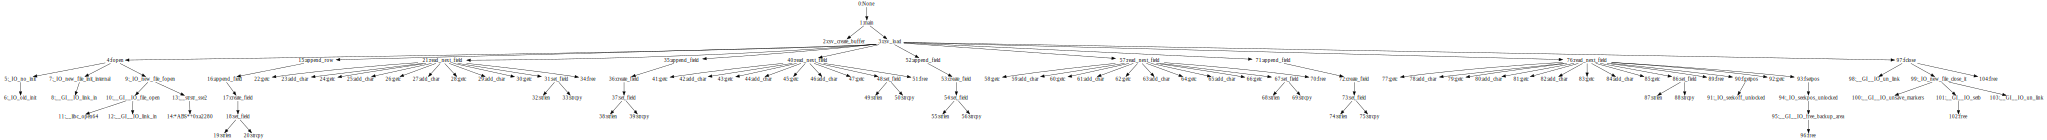

In [61]:
display_tree(csv_method_tree[0], extract_node=extract_node)

#### Identifying last comparisons
We need only the last comparisons made on any index. This means that we should care for only the last parse in an ambiguous parse. So, we assign the method that last touched an index to be its consumer.

However, to make concessions for real world, we also check if we are overwriting a child (`HEURISTIC`). Essentially, if the heursitic is enabled, then if the current method id (`midP`) is smaller than the `midC` already stored in the last comparison map, then it means that `midP` is a parent that called `midC` previously, and now accessing an index that `midC` touched. This happens when the parent tries to find a substring like `#` in the entirety of the original string. (Note that we have seen this only in `URLParser`). (Note that this heuristic does not restrict reparsing by another function call -- in such a case, `midC` will not smaller than `midP`). So, perhaps, we should let the child keep the ownership. However, there is one more wrinkle. If the character being contested was the last index touched by our `mid`, then it is likely that it was simply a boundary check. In that case, we should let the parent own this character.

In [62]:
LAST_COMPARISON_HEURISTIC = False

In [63]:
def last_comparisons(comparisons):
    last_cmp_only = {}
    last_idx = {}

    # get the last indexes compared in methods.
    for idx, char, mid in comparisons:
        if mid in last_idx:
            if idx > last_idx[mid]:
                last_idx[mid] = idx
        else:
            last_idx[mid] = idx

    for idx, char, mid in comparisons:
        if LAST_COMPARISON_HEURISTIC:
            if idx in last_cmp_only:
                midC = last_cmp_only[idx]
                if midC > mid:
                    # midC is a child of mid.
                    # do not clobber children unless it was the last character
                    # for that child.
                    if last_idx[mid] == idx:
                        # if it was the last index, may be the child used it
                        # as a boundary check.
                        pass
                    else:
                        # do not overwrite the current value of `last_cmp_only[idx]`
                        continue
        last_cmp_only[idx] = mid
    return last_cmp_only

In [64]:
csv_last_comparisons = last_comparisons(csv_trace[0]['comparisons'])
csv_last_comparisons

{0: 71,
 1: 71,
 2: 71,
 3: 71,
 4: 21,
 5: 50,
 6: 50,
 7: 50,
 8: 40,
 9: 69,
 10: 69,
 11: 69,
 12: 69,
 13: 57,
 14: 88,
 15: 88,
 16: 88,
 17: 88}

#### Attaching characters to the tree
Add the comparison indexes to the method tree that we constructed

In [65]:
def attach_comparisons(method_tree, comparisons):
    for idx in comparisons:
        mid = comparisons[idx]
        method_tree[mid]['indexes'].append(idx)

In [66]:
attach_comparisons(csv_method_tree, csv_last_comparisons)

In [67]:
csv_method_tree

{0: {'id': 0,
  'name': None,
  'children': [{'id': 1,
    'name': 'main',
    'indexes': [],
    'children': [{'id': 2,
      'name': 'csv_create_buffer',
      'indexes': [],
      'children': []},
     {'id': 3,
      'name': 'csv_load',
      'indexes': [],
      'children': [{'id': 4,
        'name': 'fopen',
        'indexes': [],
        'children': [{'id': 5,
          'name': '_IO_no_init',
          'indexes': [],
          'children': [{'id': 6,
            'name': '_IO_old_init',
            'indexes': [],
            'children': []}]},
         {'id': 7,
          'name': '_IO_new_file_init_internal',
          'indexes': [],
          'children': [{'id': 8,
            'name': '__GI__IO_link_in',
            'indexes': [],
            'children': []}]},
         {'id': 9,
          'name': '_IO_new_file_fopen',
          'indexes': [],
          'children': [{'id': 10,
            'name': '__GI__IO_file_open',
            'indexes': [],
            'children': [{'id': 11,

In [68]:
def wrap_input(istr):
    def extract_node(node, id):
        symbol = str(node['id'])
        children = node['children']
        annotation = str(node['name'])
        indexes = repr(tuple([istr[i] for i in node['indexes']]))
        return "%s %s" % (annotation, indexes), children, ''
    return extract_node

In [69]:
extract_node1 = wrap_input(csv_trace[0]['inputstr'])

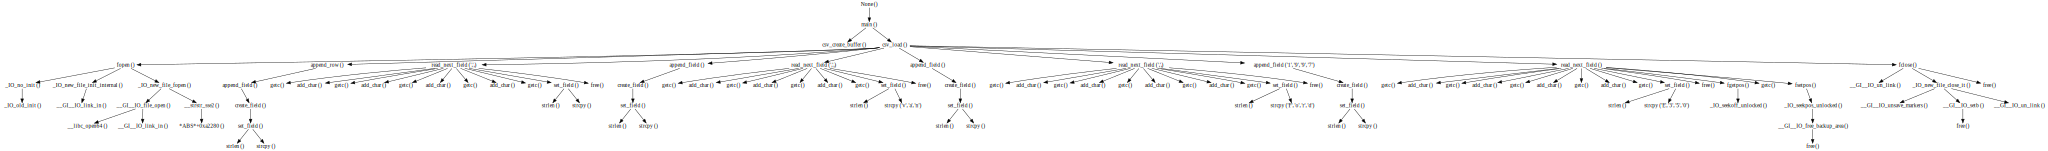

In [70]:
display_tree(csv_method_tree[0], extract_node=extract_node1)

Convert a list of indexes to a corresponding terminal tree node

In [71]:
def to_node(idxes, my_str):
    assert len(idxes) == idxes[-1] - idxes[0] + 1
    assert min(idxes) == idxes[0]
    assert max(idxes) == idxes[-1]
    return my_str[idxes[0]:idxes[-1] + 1], [], idxes[0], idxes[-1]

In [72]:
from operator import itemgetter
import itertools as it

We now need to identify the terminal (leaf) nodes. For that, we want to group contiguous letters in a node together, and call it a leaf node. So, convert our list of indexes to lists of contiguous indexes first, then convert them to terminal tree nodes. Then, return a set of one level child nodes with contiguous chars from indexes.

In [73]:
def indexes_to_children(indexes, my_str):
    lst = [
        list(map(itemgetter(1), g))
        for k, g in it.groupby(enumerate(indexes), lambda x: x[0] - x[1])
    ]

    return [to_node(n, my_str) for n in lst]

Finally, we need to remove the overlap from the trees we have so far. The idea is that, given a node, each child node of that node should be uniquely responsible for a specified range of characters, with no overlap allowed between the children. The starting of the first child to ending of the last child will be the range of the node.

#### Removing Overlap
If overlap is found, the tie is biased to the later child. That is, the later child gets to keep the range, and the former child is recursively traversed to remove overlaps from its children. If a child is completely included in the overlap, the child is excised. A few convenience functions first:

In [74]:
def does_item_overlap(r, r_):
    (s, e), (s_, e_) = r, r_
    return ((s_ >= s and s_ <= e) or 
            (e_ >= s and e_ <= e) or 
            (s_ <= s and e_ >= e))

In [75]:
def is_second_item_included(r, r_):
    (s, e), (s_, e_) = r, r_
    return (s_ >= s and e_ <= e)

In [76]:
def has_overlap(ranges, r_):
    return {r for r in ranges if does_item_overlap(r, r_)}

In [77]:
def is_included(ranges, r_):
    return {r for r in ranges if is_second_item_included(r, r_)}

In [78]:
def remove_overlap_from(original_node, orange):
    node, children, start, end = original_node
    new_children = []
    if not children:
        return None
    start = -1
    end = -1
    for child in children:
        if does_item_overlap(child[2:4], orange):
            new_child = remove_overlap_from(child, orange)
            if new_child: # and new_child[1]:
                if start == -1: start = new_child[2]
                new_children.append(new_child)
                end = new_child[3]
        else:
            new_children.append(child)
            if start == -1: start = child[2]
            end = child[3]
    if not new_children:
        return None
    assert start != -1
    assert end != -1
    return (node, new_children, start, end)

Verify that there is no overlap.

In [79]:
def no_overlap(arr):
    my_ranges = {}
    for a in arr:
        _, _, s, e = a
        r = (s, e)
        included = is_included(my_ranges, r)
        if included:
            continue  # we will fill up the blanks later.
        else:
            overlaps = has_overlap(my_ranges, r) 
            if overlaps:
                # unlike include which can happen only once in a set of
                # non-overlapping ranges, overlaps can happen on multiple parts.
                # The rule is, the later child gets the say. So, we recursively
                # remove any ranges that overlap with the current one from the
                # overlapped range.
                assert len(overlaps) == 1
                oitem = list(overlaps)[0]
                v = remove_overlap_from(my_ranges[oitem], r)
                del my_ranges[oitem]
                if v:
                    my_ranges[v[2:4]] = v
                my_ranges[r] = a
            else:
                my_ranges[r] = a
    res = my_ranges.values()
    # assert no overlap, and order by starting index
    s = sorted(res, key=lambda x: x[2])
    return s

#### Generate derivation tree

Convert a mapped tree to the _fuzzingbook_ style derivation tree.

In [80]:
def to_tree(node, my_str):
    method_name = ("<%s>" % node['name']) if node['name'] is not None else '<START>'
    indexes = node['indexes']
    node_children = [to_tree(c, my_str) for c in node.get('children', [])]
    idx_children = indexes_to_children(indexes, my_str)
    children = no_overlap([c for c in node_children if c is not None] + idx_children)
    if not children:
        return None
    start_idx = children[0][2]
    end_idx = children[-1][3]
    si = start_idx
    my_children = []
    # FILL IN chars that we did not compare. This is likely due to an i + n
    # instruction.
    for c in children:
        if c[2] != si:
            sbs = my_str[si: c[2]]
            my_children.append((sbs, [], si, c[2] - 1))
        my_children.append(c)
        si = c[3] + 1

    m = (method_name, my_children, start_idx, end_idx)
    return m

In [81]:
def is_nt(v):
    return len(v) > 1 and (v[0], v[-1]) == ('<', '>')

In [82]:
def tree_to_str(tree): # Non recursive
    expanded = []
    to_expand = [tree]
    while to_expand:
        (key, children, *rest), *to_expand = to_expand
        if is_nt(key):
            to_expand = children + to_expand
        else:
            assert not children
            expanded.append(key)
    return ''.join(expanded)

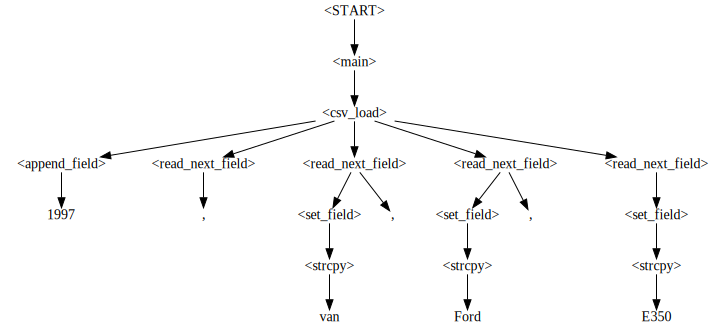

In [83]:
display_tree(to_tree(csv_method_tree[0], csv_trace[0]['inputstr']))

#### More tree examples

In [84]:
import jsonpickle

def generate_trace(inps, source):
    traces = []
    for inp in inps:
        arg0 = '\'py arg0="%s"\'' % inp
        arg1 = '\'py arg1="%s"\'' % source
        with open(f'inp.0.txt', 'w+') as f:
            print(inp, file=f)

        !gcc -g {source}
        !gdb --batch-silent -ex {arg0} -ex {arg1} -x BMiner.py
    
        with open(f'tree', 'rb') as f:
            traces.append((jsonpickle.decode(f.read())))
    return traces

In [85]:
def generate_trees_from_trace(call_traces):
    my_trees = []
    for call_trace in call_traces:
        method_map = call_trace['method_map']

        first, method_tree = reconstruct_method_tree(method_map)
        comparisons = call_trace['comparisons']
        attach_comparisons(method_tree, last_comparisons(comparisons))

        my_str = call_trace['inputstr']
        tree = to_tree(method_tree[first], my_str)
        print(my_str)
        display(display_tree(tree))

In [86]:
from fuzzingbook.GrammarMiner import URLS_X

In [87]:
inps = [
    '((1))',
    '1*(5)+(7)',
    '555+(234-445)',
    '(19)+(19-19)',
    '1-(41/2)', '12+34']
call_traces = generate_trace(inps, 'subject/calc/calc.c')

((1))


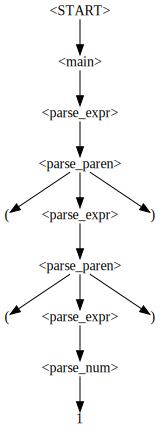

1*(5)+(7)


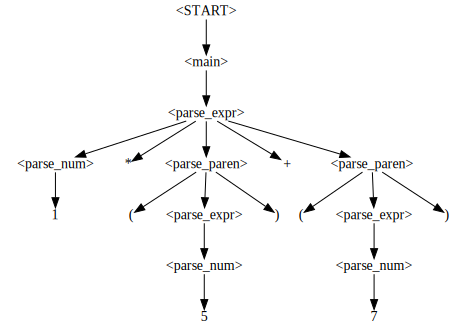

555+(234-445)


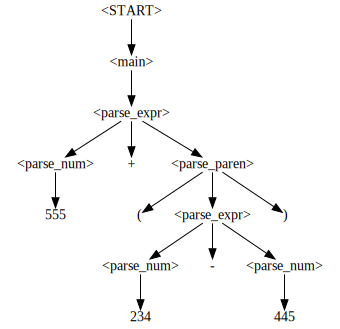

(19)+(19-19)


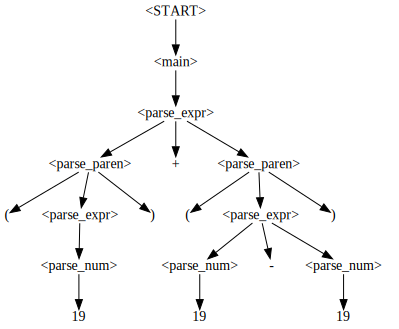

1-(41/2)


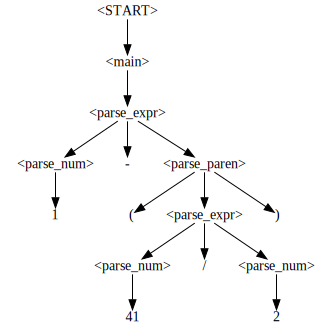

12+34


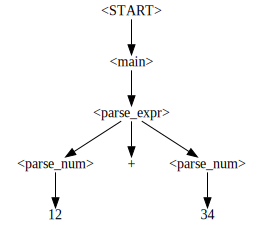

In [88]:
generate_trees_from_trace(call_traces)

In [89]:
json_samples = [i.strip() for i in '''\
{"c": [8, 7, 5], "b": {"x": "y"}}
{"color": "yellow", "x": {"a": "b"}}
{"color": [8, 7, 5], "Createewoc": {"a": "b"}}
{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}}
{"color": "blue", "category": "hue", "type": "primary"}
'''.split('\n') if i.strip()]
call_traces1 = generate_trace(json_samples, 'subject/json/json.c')

  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}L"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": b"x": "y"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": x"x": "y"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}Z"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}d"
            ^
SyntaxError: invalid syntax

  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}y"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}m"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}k"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"c": [8, 7, 5], "b": {"x": "y"}}"
            ^
SyntaxError: invalid syntax

  File "<string>", line 1
    arg0="{"color": "yellow", "x"d {"a"f "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x"P {"a"M "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow",Z"x":L{"a":c"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow",K"x":V{"a":S"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x"O {"a"k "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x"N {"a"d "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow",q"x":D{"a":j"b"}}"
            ^
Syntax

  File "<string>", line 1
    arg0="{"color": "yellow", "x": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x": {"a": "b"}b"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x": {"a": "b"}A"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x": {"a": "b"}v"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "yellow", "x": {"a": "b"}}"
            ^
Syntax

  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a":C"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": Q"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": u"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}X"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0

  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}R"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}H"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}e"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 7, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0

  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick":U"Createewoc",O"x":w{"a":M"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc",y"x":N{"a":Z"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8,I7,v5]w,g"onclick":F"Createewoc",c"x":W{"a":c"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7,r5]r,V"onclick":I"Createewoc",Z"x":C{"a":x"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5]l,W"onclick":Z"Createewoc",f"x":J{"a":U"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] ,C"onclick":f"Createewoc",x"x":Q{"a":m"b"}}"
         

  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a":Q"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8,V7,N5]U,K"onclick":j"Createewoc",s"x":p{"a":l"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7,c5]B,l"onclick":C"Createewoc",I"x":Q{"a":x"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5]l,r"onclick":L"Createewoc",C"x":s{"a":G"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] ,b"onclick":u"Createewoc",M"x":e{"a":V"b"}}"
         

  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}Y"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}M"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}V"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}}"
         

  File "<string>", line 1
    arg0="{"color": "blue", "category": "hue", "type": "primary"}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.


{"c": [8, 7, 5], "b": {"x": "y"}}


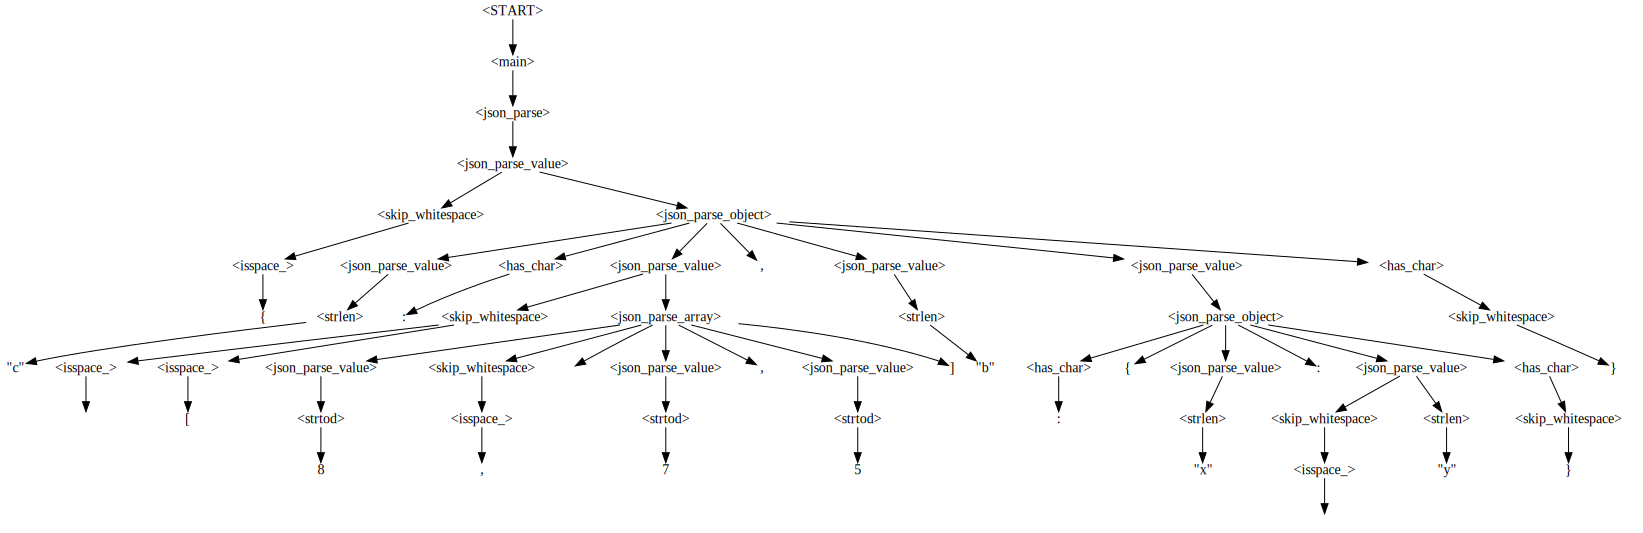

{"color": "yellow", "x": {"a": "b"}}


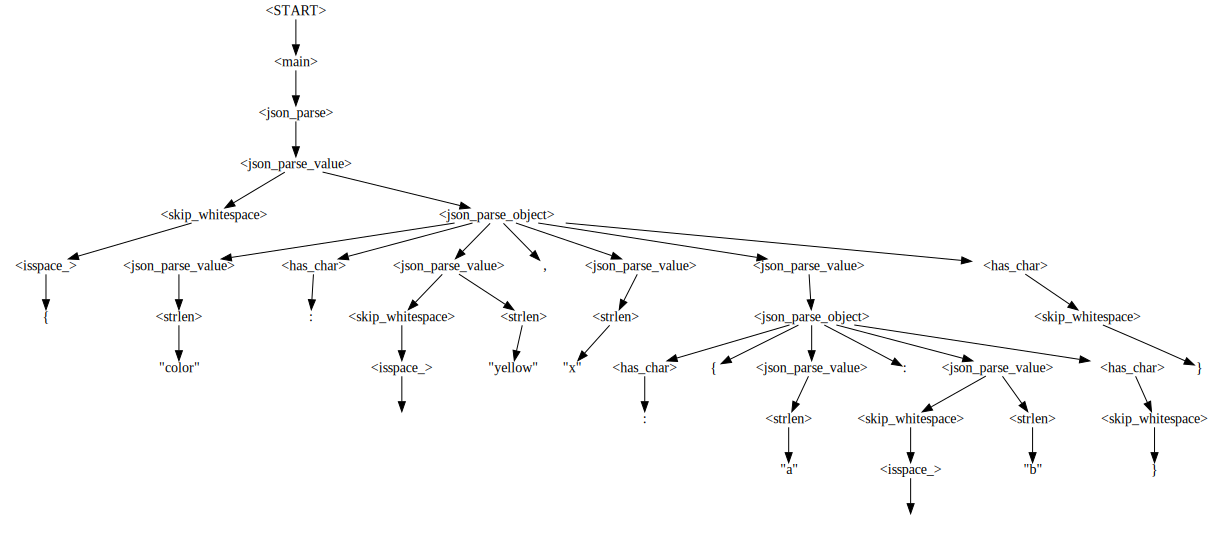

{"color": [8, 7, 5], "Createewoc": {"a": "b"}}


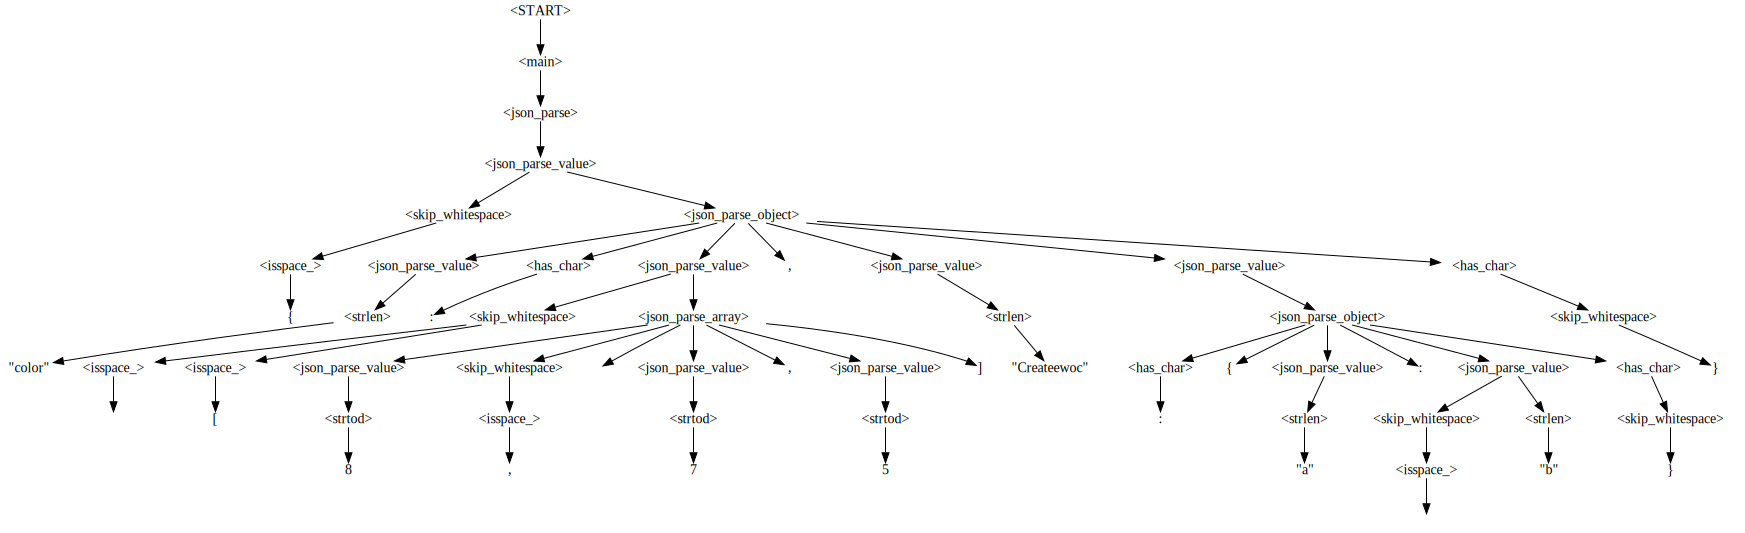

{"array": [8, 7, 5] , "onclick": "Createewoc", "x": {"a": "b"}}


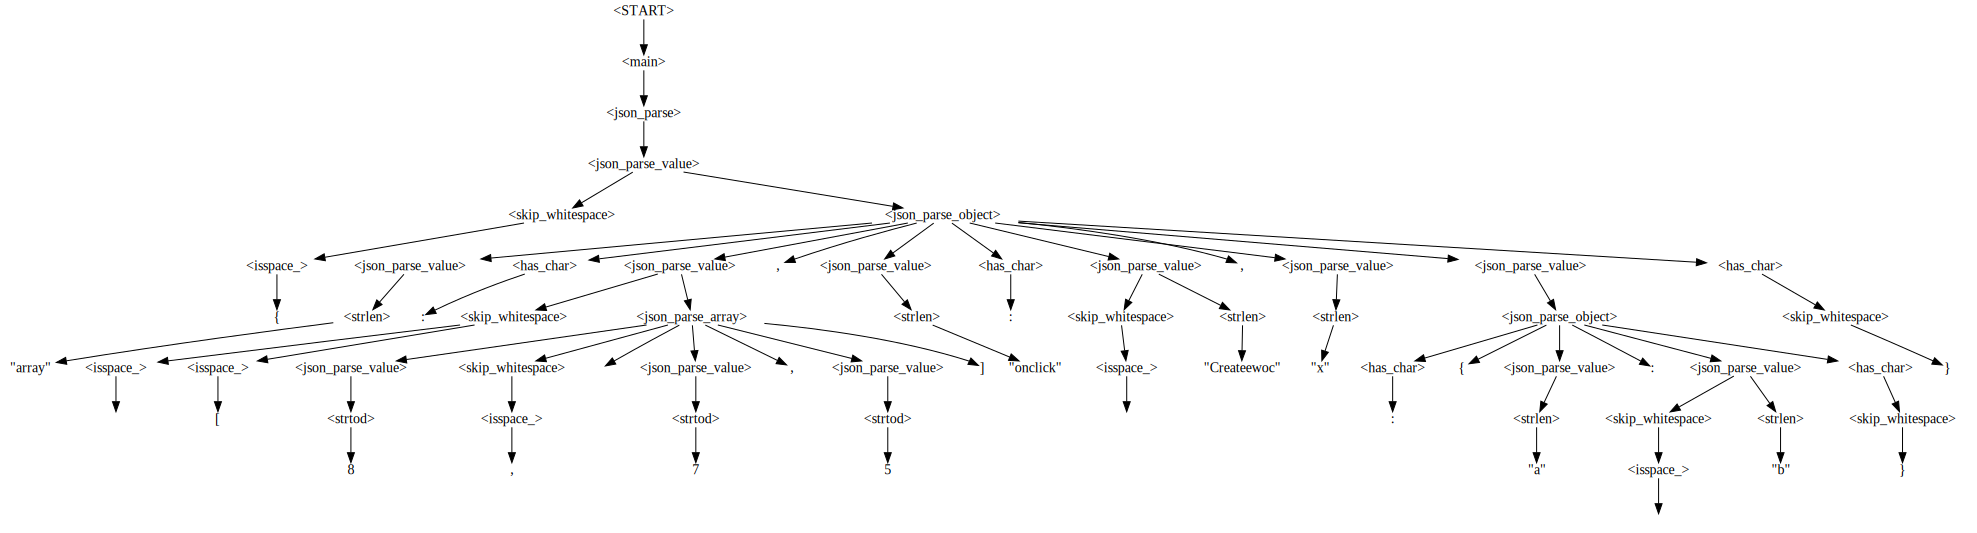

{"color": "blue", "category": "hue", "type": "primary"}


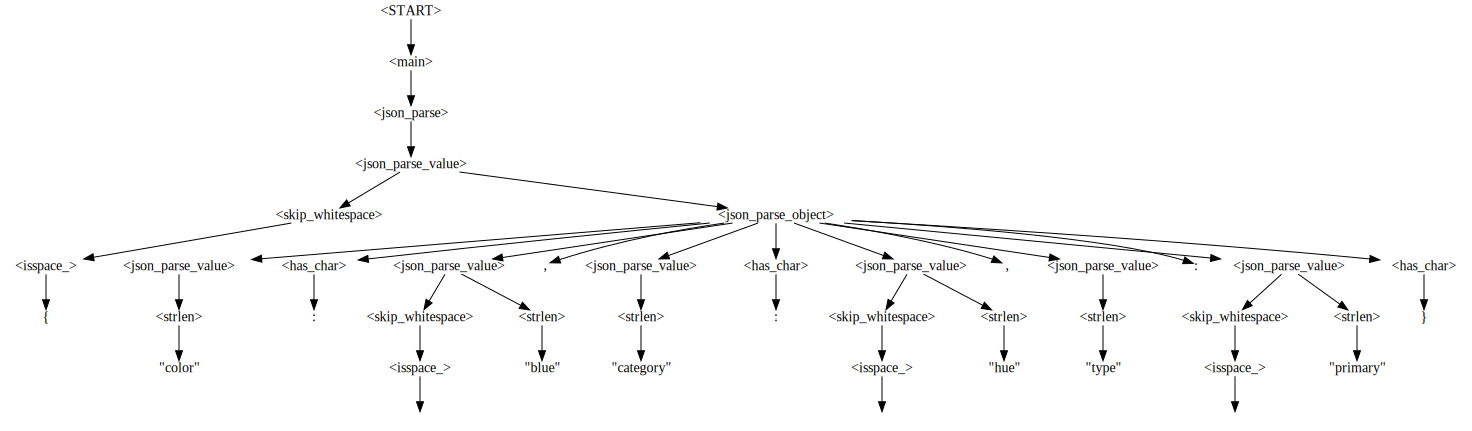

In [90]:
generate_trees_from_trace(call_traces1)

## Generating a Grammar

Generating a grammar from the generalized derivation trees is pretty simple. Start at the start node, and any node that represents a method or a pseudo method becomes a nonterminal. The children forms alternate expansions for the nonterminal. Since all the keys are compatible, merging the grammar is simply merging the hash map.

First, we define a pretty printer for grammar.

In [91]:
import re
RE_NONTERMINAL = re.compile(r'(<[^<> ]*>)')

In [92]:
def recurse_grammar(grammar, key, order, canonical):
    rules = sorted(grammar[key])
    old_len = len(order)
    for rule in rules:
        if not canonical:
            res =  re.findall(RE_NONTERMINAL, rule)
        else:
            res = rule
        for token in res:
            if token.startswith('<') and token.endswith('>'):
                if token not in order:
                    order.append(token)
    new = order[old_len:]
    for ckey in new:
        recurse_grammar(grammar, ckey, order, canonical)

In [93]:
def show_grammar(grammar, start_symbol='<START>', canonical=True):
    order = [start_symbol]
    recurse_grammar(grammar, start_symbol, order, canonical)
    if len(order) != len(grammar.keys()):
        assert len(order) < len(grammar.keys())
    return {k: sorted(grammar[k]) for k in order}

### Trees to grammar

In [94]:
def to_grammar(tree, grammar):
    node, children, _, _ = tree
    if not children: return grammar
    tokens = []
    if node not in grammar:
        grammar[node] = list()
    for c in children:
        tokens.append(c[0])
        to_grammar(c, grammar)
    grammar[node].append(tuple(tokens))
    return grammar

In [95]:
def merge_grammar(g1, g2):
    all_keys = set(list(g1.keys()) + list(g2.keys()))
    merged = {}
    for k in all_keys:
        alts = set(g1.get(k, []) + g2.get(k, []))
        merged[k] = alts
    return {k:[l for l in merged[k]] for k in merged}

In [96]:
def convert_to_grammar(my_trees):
    grammar = {}
    ret = []
    for my_tree in my_trees:
        tree = my_tree['tree']
        start = tree[0]
        src_file = my_tree['original']
        arg_file = my_tree['arg']
        ret.append((start, src_file, arg_file))
        g = to_grammar(tree, grammar)
        grammar = merge_grammar(grammar, g)
    return grammar

### The Complete Miner

We now put everything together. The `miner()` takes the traces, produces trees out of them, and verifies that the trees actually correspond to the input.

In [97]:
def miner(call_traces):
    my_trees = []
    for call_trace in call_traces:
        method_map = call_trace['method_map']

        first, method_tree = reconstruct_method_tree(method_map)
        comparisons = call_trace['comparisons']
        attach_comparisons(method_tree, last_comparisons(comparisons))

        my_str = call_trace['inputstr']

        tree = to_tree(method_tree[first], my_str)
        my_tree = {'tree': tree, 'original': call_trace['original'], 'arg': call_trace['arg']}
        print(tree_to_str(tree))
        assert tree_to_str(tree) == my_str
        my_trees.append(my_tree)
    return my_trees

In [98]:
import jsonpickle
from fuzzingbook.Parser import non_canonical, canonical

In [99]:
def binary_miner(seeds, executable, flag=None):
    call_trace = []
    for inp in seeds:
        arg0 = '\'py arg0="%s"\'' % inp
        arg1 = '\'py arg1="%s"\'' % executable
        
        with open(f'inp.0.txt', 'w+') as f:
            print(inp, file=f)
        
        if flag:
            !gcc -g {executable} {flag}
            with open(f'flag.txt', 'w+') as f:
                print(flag, file=f)
        else:
            !gcc -g {executable}       
        
        !gdb --batch-silent -ex {arg1} -x BMiner.py
        with open(f'tree', 'rb') as f:
            call_trace.append((jsonpickle.decode(f.read())))
            
    mined_tree = miner(call_trace)
    g0 = convert_to_grammar(mined_tree)
    #g = cleanup_grammar(g0, start_symbol='<START>')
    #g = compact_grammar(g, start_symbol='<START>')
    return show_grammar(non_canonical(g0), canonical=False)

# Evaluation

## Initialization

In [100]:
Max_Precision = 1000
Max_Recall = 1000
BMiner = {}
BMinerFuzz = {}
BMinerGrammar = {}
MaxTimeout = 60*60*24 # 2 day
MaxParseTimeout = 60*5
CHECK = {'calculator', 'json', 'url', 'csv', 'lisp', 'tinyc', 'mjs'}

In [101]:
def clean_build():
    !rm a.out
    !rm inp.0.txt
    !rm gdb.txt
    !rm updated_comparisons
    !rm tree
    !rm comparison.txt
    !rm check
    !rm flag.txt

### Check Recall

How many of the *valid* inputs from the golden grammar can be recognized by a parser using our grammar?

In [102]:
from fuzzingbook.Parser import IterativeEarleyParser

In [103]:
def check_recall(golden_grammar, my_grammar, maximum=Max_Recall, start_symbol='<START>', log=False):
    my_count = maximum
    ie = IterativeEarleyParser(my_grammar, start_symbol=start_symbol)
    golden = GrammarFuzzer(golden_grammar, start_symbol=start_symbol)
    success = 0
    while my_count != 0:
        src = golden.fuzz()
        try:
            my_count -= 1
            try:
                # print('?', repr(src), file=sys.stderr)
                for tree in ie.parse(src):
                    success += 1
                    break
                if log: print(maximum - my_count, '+', repr(src), success, file=sys.stderr)
            except:
                #print("Error:", sys.exc_info()[0], file=sys.stderr)
                if log: print(maximum - my_count, '-', repr(src), file=sys.stderr)
                pass
        except:
            pass
    return (success, maximum)

### Check Precision
How many of the inputs produced using our grammar are valid? (Accepted by the program).

In [104]:
from fuzzingbook.ExpectError import ExpectError, ExpectTimeout

In [105]:
check_it_src = '''
import gdb, subprocess, os

flag = None
if os.path.exists('flag.txt'):
    with open(f'flag.txt', 'r+') as f:
        flag = f.read().strip()
        subprocess.call(['gcc', '-g', arg1, flag])
else:
    subprocess.call(['gcc', '-g', arg1])

gdb.execute('file a.out')
gdb.execute("set args '%s'" % arg0)
gdb.execute('run')
'''
with open('check_it.py', 'w+') as f:
    print(check_it_src, file=f)

In [106]:
import subprocess

def check_it(s, module):
    with open(f'inp.0.txt', 'w+') as f:
        print(s, file=f)
    
    result = subprocess.Popen(['gdb', 'batch-silent', '-ex', 'py arg0="%s"' % s, '-ex', 'py arg1="%s"' % module, '-x', 'check_it.py'],
                stdin = subprocess.PIPE,
                stdout = subprocess.PIPE,
                stderr = subprocess.STDOUT)
    stdout, stderr = result.communicate()
    stdout = stdout.decode('utf-8')
    return stdout.endswith('exited normally]\n(gdb) quit\n')

In [107]:
def check_precision(name, grammar, maximum=Max_Precision, start_symbol='<START>', log=False):
    success = 0
    with ExpectError():
        fuzzer = GrammarFuzzer(grammar, start_symbol)
        for i in range(maximum):
            v = fuzzer.fuzz()
            c = check_it(v, name)
            success += (1 if c else 0)
            if log: print(i, repr(v), c)
    return (success, maximum)

In [108]:
class timeit():
    def __enter__(self):
        self.tic = datetime.now()
        return self
    def __exit__(self, *args, **kwargs):
        self.delta = datetime.now() - self.tic
        self.runtime = (self.delta.microseconds, self.delta)

### Timer

In [109]:
from datetime import datetime
from fuzzingbook.GrammarFuzzer import GrammarFuzzer

## Subjects

In [110]:
BMiner_p = {}
BMiner_r = {}

BMiner_t ={}

### Calculator

####  Golden Grammar

In [111]:
calc_golden = {
  "<START>": [
    "<expr>"
  ],
  "<expr>": [
    "<term>+<expr>",
    "<term>-<expr>",
    "<term>"
  ],
  "<term>": [
    "<factor>*<term>",
    "<factor>/<term>",
    "<factor>"
  ],
  "<factor>": [
    "(<expr>)",
    "<number>"
  ],
  "<number>": [
    "<integer>.<integer>",
    "<integer>"
  ],
  "<integer>": [
    "<digit><integer>",
    "<digit>"
  ],
  "<digit>": [ "0", "1", "2", "3", "4", "5", "6", "7", "8", "9" ]
}

#### Samples

In [112]:
calc_samples=[i.strip() for i in '''\
1*(5)+(7)
12+34
(19)+(19-19)
(1+2)*3/(423-334+9983)-5-((6)-(701))
(123+133*(12-3)/9+8)+33
(100)
21*3
33/44+2
100
23*234*22*4
1+2
31/20-2
555+(234-445)
1-(41/2)
443-334+33-222
'''.split('\n') if i.strip()]

In [113]:
calc_grammar = binary_miner(calc_samples, 'subject/calc/calc.c')
canonical(calc_grammar)

1*(5)+(7)
12+34
(19)+(19-19)
(1+2)*3/(423-334+9983)-5-((6)-(701))
(123+133*(12-3)/9+8)+33
(100)
21*3
33/44+2
100
23*234*22*4
1+2
31/20-2
555+(234-445)
1-(41/2)
443-334+33-222


{'<START>': [['<main>']],
 '<main>': [['<parse_expr>']],
 '<parse_expr>': [['<parse_num>'],
  ['<parse_num>', '*', '<parse_num>'],
  ['<parse_num>', '*', '<parse_num>', '*', '<parse_num>', '*', '<parse_num>'],
  ['<parse_num>', '*', '<parse_paren>', '+', '<parse_paren>'],
  ['<parse_num>', '+', '<parse_num>'],
  ['<parse_num>',
   '+',
   '<parse_num>',
   '*',
   '<parse_paren>',
   '/',
   '<parse_num>',
   '+',
   '<parse_num>'],
  ['<parse_num>', '+', '<parse_paren>'],
  ['<parse_num>', '-', '<parse_num>'],
  ['<parse_num>', '-', '<parse_num>', '+', '<parse_num>'],
  ['<parse_num>', '-', '<parse_num>', '+', '<parse_num>', '-', '<parse_num>'],
  ['<parse_num>', '-', '<parse_paren>'],
  ['<parse_num>', '/', '<parse_num>'],
  ['<parse_num>', '/', '<parse_num>', '+', '<parse_num>'],
  ['<parse_num>', '/', '<parse_num>', '-', '<parse_num>'],
  ['<parse_paren>'],
  ['<parse_paren>',
   '*',
   '<parse_num>',
   '/',
   '<parse_paren>',
   '-',
   '<parse_num>',
   '-',
   '<parse_paren>'

In [114]:
if 'calculator' in CHECK:
    result = check_recall(calc_golden, calc_grammar, start_symbol='<START>')
    BMiner_r['calc.c'] = result
    print(result)

(23, 1000)


In [115]:
result = check_precision('subject/calc/calc.c', calc_grammar)
BMiner_p['calc.c'] = result
print(result)

(1000, 1000)


In [116]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


### CSV 

#### The Golden Grammar

In [117]:
import string

CSV_GRAMMAR = {
    '<START>': ['<csvline>'],
    '<csvline>': ['<items>'],
    '<items>': ['<item>,<items>', '<item>'],
    '<item>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>': list(string.ascii_letters + string.digits + string.punctuation + ' \t\n')
}

#### Samples

In [118]:
from fuzzingbook.GrammarMiner import VEHICLES
VEHICLES

['1997,van,Ford,E350', '2000,car,Mercury,Cougar', '1999,car,Chevy,Venture']

In [119]:
csv_grammar = binary_miner(VEHICLES, 'subject/csv/csv.c')
canonical(csv_grammar)

1997,van,Ford,E350
2000,car,Mercury,Cougar
1999,car,Chevy,Venture


{'<START>': [['<main>']],
 '<main>': [['<csv_load>']],
 '<csv_load>': [['<append_field>',
   '<read_next_field>',
   '<read_next_field>',
   '<read_next_field>',
   '<read_next_field>']],
 '<append_field>': [['1997'], ['1999'], ['2000']],
 '<read_next_field>': [[','], ['<set_field>'], ['<set_field>', ',']],
 '<set_field>': [['<strcpy>']],
 '<strcpy>': [['Chevy'],
  ['Cougar'],
  ['E350'],
  ['Ford'],
  ['Mercury'],
  ['Venture'],
  ['car'],
  ['van']]}

In [120]:
if 'csv' in CHECK:
    result = check_recall(CSV_GRAMMAR, csv_grammar, start_symbol='<START>')
    BMiner_r['csv.c'] = result
    print(result)

(0, 1000)


In [121]:
result = check_precision('subject/csv/csv.c', csv_grammar)
BMiner_p['csv.c'] = result
print(result)

(1000, 1000)


In [122]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


### Url parser

#### Golden Grammar

In [123]:
urlparse_golden = {
  "<START>": [
    "<url>"
  ],
  "<url>": [
    "<scheme>://<authority><path><query>"
  ],
  "<scheme>": [
    "http",
    "https",
    "ftp",
    "ftps"
  ],
  "<authority>": [
    "<host>",
#    "<host>:<port>",
#    "<userinfo>@<host>",
#    "<userinfo>@<host>:<port>"
  ],
#  "<user>": [
#    "user1",
#    "user2",
#    "user3",
#    "user4",
#    "user5"
#  ],
#  "<pass>": [
#    "pass1",
#    "pass2",
#    "pass3",
#    "pass4",
#    "pass5"
#  ],

  "<host>": [
    "host1",
    "host2",
    "host3",
    "host4",
    "host5"
  ],
# "<port>": [
#   "<nat>"
# ],
# "<nat>": [
#   "10",
#   "20",
#   "30",
#   "40",
#   "50"
# ],
# "<userinfo>": [
#   "<user>:<pass>"
# ],
  "<path>": [
    "",
    "/",
    "/<id>",
    "/<id><path>"
  ],
  "<id>": [
    "folder"
  ],
  "<query>": [
    "",
    "?<params>"
  ],
  "<params>": [
    "<param>",
    "<param>&<params>"
  ],
  "<param>": [
    "<key>=<value>"
  ],
  "<key>": [
    "key1",
    "key2",
    "key3",
    "key4"
  ],
  "<value>": [
    "value1",
    "value2",
    "value3",
    "value4"
  ]
}

#### Samples

In [124]:
gf = GrammarFuzzer(urlparse_golden, start_symbol='<START>')
urlparse_samples = [gf.fuzz() for i in range(10)]
urlparse_samples

['http://host1',
 'ftp://host4/?key2=value4',
 'ftps://host2/?key2=value4',
 'http://host2/folder?key4=value3',
 'https://host2/folder/',
 'ftps://host1?key2=value3&key4=value4&key2=value1',
 'ftps://host3/folder/folder?key1=value1&key1=value4&key3=value4',
 'ftp://host3',
 'http://host3/folder',
 'ftps://host4/?key1=value3']

In [125]:
url_grammar = binary_miner(urlparse_samples, 'subject/url/url.c')
canonical(url_grammar)

http://host1
ftp://host4/?key2=value4
ftps://host2/?key2=value4
http://host2/folder?key4=value3
https://host2/folder/
ftps://host1?key2=value3&key4=value4&key2=value1
ftps://host3/folder/folder?key1=value1&key1=value4&key3=value4
ftp://host3
http://host3/folder
ftps://host4/?key1=value3


{'<START>': [['<main>']],
 '<main>': [['<url_parse>']],
 '<url_parse>': [['<url_scheme_parse>', '<strlen>'],
  ['<url_scheme_parse>', '<strlen>', '<strlen>'],
  ['<url_scheme_parse>', '<strlen>', '<strncpy>', '<strlen>'],
  ['<url_scheme_parse>', 'h', '<strlen>'],
  ['<url_scheme_parse>', 'h', '<strlen>', '<strncpy>', '<strlen>']],
 '<url_scheme_parse>': [['<tolower>', '<tolower>', '<tolower>', '://'],
  ['<tolower>', '<tolower>', '<tolower>', '<tolower>', '://'],
  ['<tolower>', '<tolower>', '<tolower>', '<tolower>', '<tolower>', '://']],
 '<strlen>': [['/folder'],
  ['/folder/'],
  ['host1'],
  ['host2'],
  ['host3'],
  ['key1=value1&key1=value4&key3=value4'],
  ['key1=value3'],
  ['key2=value4'],
  ['key4=value3'],
  ['ost1?key2=value3&key4=value4&key2=value1'],
  ['ost2'],
  ['ost3'],
  ['ost4']],
 '<strncpy>': [['/?'], ['/folder/folder?'], ['/folder?']],
 '<tolower>': [['f'], ['h'], ['p'], ['s'], ['t']]}

In [126]:
if 'url' in CHECK:
    result = check_recall(urlparse_golden, url_grammar, start_symbol='<START>')
    BMiner_r['url.c'] = result
    print(result)

(231, 1000)


In [127]:
result = check_precision('subject/url/url.c', url_grammar)
BMiner_p['url.c'] = result
print(result)

(1000, 1000)


In [128]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


### JSON


#### Golden Grammar

In [129]:
json_golden = {
    "<START>": [ ["<json>"] ],
    "<json>": [ ["<element>"] ],
    "<value>": [
        ["<object>"],
        ["<array>"],
        ["<string>"],
        ["<number>"],
        ["true"],
        ["false"],
        ["null"],
    ],
    "<object>": [ ["{", "<ws>", "<members>", "<ws>", "}"], ],
    "<members>": [
        ["<member>", ",", "<members>"],
        ["<member>"]
    ],
    "<member>": [ ["<ws>", "<string>", "<ws>", ":", "<element>"] ],
    "<array>": [
        ["[", "<ws>", "]"],
        ["[", "<elements>", "]"],
    ],
    "<elements>": [ ["<element>", ",", "<elements>"], ["<element>"], ],
    "<element>": [ ["<ws>", "<value>", "<ws>"], ],
    "<string>": [ ["\"","<characters>","\""] ],
    "<characters>": [ ["<character>", "<characters>"], [] ],
    "<character>":  [[s] for s in string.printable if s not in {"\"", "\\"}] +
    [["\\", "<escape>"]],
    "<escape>": [[c] for c in '"\\/bfnrt"'] + [["u", "<hex>", "<hex>", "<hex>", "<hex>"]],
    "<hex>": [
        ["<digit>" ],
        ["a"], ["b"], ["c"], ["d"], ["e"], ["f"],
        ["A"], ["B"], ["C"], ["D"], ["E"], ["F"]
    ],
    "<number>": [ ["<integer>", "<fraction>", "<exponent>"] ],
    "<integer>": [
        ["<onenine>","<digits>"],
        ["<digit>"],
        ["-","<digit>"],
        ["-", "<onenine>","<digits>"],
    ],
    "<digits>": [ ["<digit>", "<digits>"], ["<digit>"], ],
    "<digit>": [ ["0"], ["<onenine>"], ],
    "<onenine>": [ ["1"],  ["2"],  ["3"],  ["4"],  ["5"], ["6"],  ["7"],  ["8"],  ["9"] ],
    "<fraction>": [ [".", "<digits>"], [] ],
    "<exponent>" :[ ["E", "<sign>", "<digits>"], ["e", "<sign>", "<digits>"], [] ],
    "<sign>": [ ["+"], ["-"], [] ],
    "<ws>": [ [" ", "<ws>"], [] ]
}


In [130]:
def non_canonical(grammar):
    return {k: [''.join(r) for r in grammar[k]] for k in grammar}
json_golden = non_canonical(json_golden)

#### Samples

In [131]:
json_samples = [i.strip() for i in '''\
{"color": [8, 67, 9, 9]}
{"value": "New", "onclick": "CreateNewDoc()"}
{"color": "blue", "category": "hue","type": "primary"}
{"color": [8, 743, 5], "Createewoc": {"a": "b"}}
{"color": "green", "category": "hue", "type": "secondary"}
'''.split('\n') if i.strip()]

In [132]:
json_grammar = binary_miner(json_samples, 'subject/json/json.c')
canonical(json_grammar)

  File "<string>", line 1
    arg0="{"color": [8,L67,b9,x9]}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8,Z67,d9,f9]}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 67P 9M 9]}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 67Z 9L 9]}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 67c 9K 9]}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 67V 9S 9]}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 67, 9, 2]}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
 

  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc"d {"a"f "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc"P {"a"M "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8,Z743,L5],c"Createewoc":K{"a":V"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8,S743,O5],k"Createewoc":N{"a":d"b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743q 5]D "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743j 5]e "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", lin

  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc": {"a": "b"}y"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc": {"a": "b"}m"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc": {"a": "b"}}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": [8, 743, 5], "Createewoc": {"a": "b"}k"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", lin

  File "<string>", line 1
    arg0="{"color": "green",d"category":f"hue",P"type":M"secondary"}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "green",Z"category":L"hue",c"type":K"secondary"}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "green", "category"V "hue", "type"S "secondary"}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "green", "category"O "hue", "type"k "secondary"}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "green",N"category":d"hue",q"type":D"secondary"}"
            ^
SyntaxError: invalid syntax
Error while executing Python code.
  File "<string>", line 1
    arg0="{"color": "green", "category":j"hue",e"type":P"secondary"}"
            ^
SyntaxError: invalid synt

{'<START>': [['<main>']],
 '<main>': [['<json_parse>']],
 '<json_parse>': [['<json_parse_value>']],
 '<json_parse_value>': [['<json_parse_object>'],
  ['<skip_whitespace>', '<json_parse_array>'],
  ['<skip_whitespace>', '<json_parse_object>'],
  ['<skip_whitespace>', '<strlen>'],
  ['<skip_whitespace>', '<strtod>'],
  ['<strlen>'],
  ['<strtod>']],
 '<json_parse_object>': [['<has_char>',
   ' {',
   '<json_parse_value>',
   ':',
   '<json_parse_value>',
   '<has_char>'],
  ['<json_parse_value>',
   '<has_char>',
   '<json_parse_value>',
   ', ',
   '<json_parse_value>',
   ':',
   '<json_parse_value>',
   '<has_char>'],
  ['<json_parse_value>',
   '<has_char>',
   '<json_parse_value>',
   ', ',
   '<json_parse_value>',
   '<has_char>',
   '<json_parse_value>',
   ', ',
   '<json_parse_value>',
   ':',
   '<json_parse_value>',
   '<has_char>'],
  ['<json_parse_value>',
   '<has_char>',
   '<json_parse_value>',
   ', ',
   '<json_parse_value>',
   '<has_char>',
   '<json_parse_value>',
 

In [133]:
if 'json' in CHECK:
    result = check_recall(json_golden, json_grammar, start_symbol='<START>')
    BMiner_r['json.c'] = result
    print(result)

(3, 1000)


In [134]:
result = check_precision('subject/json/json.c', json_grammar)
BMiner_p['json.c'] = result
print(result)

(281, 1000)


In [135]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


### Lisp

In [136]:
import sys
sys.setrecursionlimit(50000)

#### Golden Grammar

In [137]:
import string
lisp_golden = {
    '<START>': [ '<sexpr>' ],
    '<sexpr>': [ '<atom>', '<list>' ],
    '<atom>': ['<id>', '<digits>', '<string>' ],
    '<list>': [ '(<whitespace><sexprs><whitespace>)'],
    '<sexprs>': [ '', '<sexpr><space><whitespace><sexprs>'],
    '<id>': ['<letter><alphanums>'],
    '<alphanums>': [ '', '<alphanum><alphanums>'],
    '<alphanum>' : ['<letter>', '<digit>'],
    '<digit>': [i for i in string.digits],
    '<space>': [' '],
    '<whitespace>' : ['', '<space><whitespace>'],
    '<letter>' : [i for i in string.ascii_letters],
    '<digits>': ['<digit>', '<digit>''<digits>'],
    '<sletter>': ['<space>', '<digit>', '<letter>'],
    '<sletters>': ['', '<sletter><sletters>'],
    '<string>': ['"<sletters>"']
}

#### Samples

In [138]:
lisp_samples=[i.strip() for i in '''\
(+ 12)
(* 2(cos 0))
(- 4 6)
(* 3 5)
'''.split('\n') if i.strip()]

In [139]:
lisp_grammar = binary_miner([lisp_samples[0]], 'subject/lisp/lisp.c', '-lm')
canonical(lisp_grammar)

(+ 12)


{'<START>': [['<main>']],
 '<main>': [['<lisp_init_lib>']],
 '<lisp_init_lib>': [['<lisp_init_lib_opt>']],
 '<lisp_init_lib_opt>': [['<lisp_table_define_funcs>']],
 '<lisp_table_define_funcs>': [['<lisp_make_symbol>']],
 '<lisp_make_symbol>': [['<hash_string>'], ['<lexer_next_token>']],
 '<hash_string>': [['<lexer_next_token>'],
  ['<parse_list_r>'],
  ['<strlen>'],
  ['<table_get_string>'],
  ['<toupper>']],
 '<lexer_next_token>': [['<lexer_next_token>'],
  ['<lexer_skip_empty>'],
  ['<lexer_skip_empty>', '<parse_list_r>'],
  ['<lisp_make_symbol>'],
  ['<parse_list_r>']],
 '<parse_list_r>': [['<lexer_next_token>'],
  ['<lisp_eval>', ' ', '<parse_atom>'],
  ['<parse_atom>']],
 '<strlen>': [['<lexer_next_token>'], ['<memcpy>']],
 '<table_get_string>': [['<lexer_next_token>'],
  ['<parse_list_r>'],
  ['<strlen>'],
  ['<strncasecmp>']],
 '<toupper>': [['<expand_r>'],
  ['<lexer_next_token>'],
  ['<lisp_make_symbol>'],
  ['<lisp_read>'],
  ['<parse_list_r>'],
  ['<strlen>'],
  ['<table_get

In [140]:
if 'lisp' in CHECK:
    result = check_recall(lisp_golden, lisp_grammar, start_symbol='<START>')
    BMiner_r['lisp.c'] = result
    print(result)

(146, 1000)


In [141]:
result = check_precision('subject/lisp/lisp.c', lisp_grammar)
BMiner_p['lisp.c'] = result
print(result)

(999, 1000)


In [142]:
clean_build()

rm: cannot remove 'updated_comparisons': No such file or directory
rm: cannot remove 'comparison.txt': No such file or directory
rm: cannot remove 'check': No such file or directory


### TinyC


#### Golden Grammar

In [143]:
import string
tinyC_golden = {
    '<START>': ['<program>'],
    '<program>': ['<statement>'],
    '<statement>': ['if <paren_expr> <statement>', 'if <paren_expr> <statement> else <statement>',
                   'while <paren_expr> <statement>', 'do <statement> while <paren_expr>;',
                   '{ <statement> }', '<expr> ;', ';'],
    '<paren_expr>': ['(<expr>)'],
    '<expr>': ['<test>', '<id>=<expr>'],
    '<test>': ['<sum>', '<sum><<sum>'],
    '<sum>': ['<term>', '<sum>+<term>', '<sum>-<term>'],
    '<term>': ['<id>', '<int>', '<paren_expr>'],
    '<id>': list(string.ascii_lowercase),
    '<int>': list(string.digits)
}

#### Samples

In [144]:
tinyC_samples=[i.strip() for i in '''\
a=b=c=2<3;
i = 25
{i = 1;}
'''.split('\n') if i.strip()]

In [145]:
tiny_grammar = binary_miner(tinyC_samples, 'subject/tinyC/tiny.c')
canonical(tiny_grammar)

syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
syntax error
a=b=c=2<3;
i = 25
{i = 1;}


{'<START>': [['<main>']],
 '<main>': [['<parse_expr>']],
 '<parse_expr>': [['<program>']],
 '<program>': [['<next_sym>', '<statement>']],
 '<next_sym>': [['<next_ch>'], ['<next_ch>', '<next_ch>']],
 '<statement>': [['<expr>'], ['<next_sym>', '<statement>']],
 '<next_ch>': [[' '],
  ['1'],
  ['2'],
  ['3'],
  ['5'],
  [';'],
  ['<'],
  ['='],
  ['a'],
  ['b'],
  ['c'],
  ['i'],
  ['{'],
  ['}']],
 '<expr>': [['<test>'],
  ['<test>', '<next_sym>'],
  ['<test>', '<next_sym>', '<expr>']],
 '<test>': [['<sum>'], ['<sum>', '<next_sym>']],
 '<sum>': [['<term>']],
 '<term>': [['<next_sym>']]}

In [146]:
if 'tinyc' in CHECK:
    result = check_recall(tinyC_golden, tiny_grammar, start_symbol='<START>')
    BMiner_r['tinyc.c'] = result
    print(result)

(16, 1000)


In [147]:
result = check_precision('subject/tinyC/tiny.c', tiny_grammar)
BMiner_p['tiny.c'] = result
print(result)

(5, 1000)


In [148]:
clean_build()

rm: cannot remove 'flag.txt': No such file or directory


## Results

In [149]:
from IPython.display import HTML, display

In [150]:
def show_table(keys, autogram, title, fn):
    keys = [k for k in keys if k in autogram and autogram[k]]
    tbl = ['<tr>%s</tr>' % ''.join(["<th>%s</th>" % k for k in ['<b>%s</b>' % title,'Binary Miner']])]
    for k in keys:
        h_c = "<td>%s</td>" % k
        a_c = "<td>%s</td>" % fn(autogram.get(k,('',0)))
        tbl.append('<tr>%s</tr>' % ''.join([h_c, a_c]))
    return display(HTML('<table>%s</table>' % '\n'.join(tbl)))

### Table 1 (Recall)

How many *valid* inputs generated by the golden grammar or collected externally are parsable by a parser using our grammar?

In [151]:
def percentage_fn(x):
    return "%s%%" % (x[0]*100.0/x[1])

In [152]:
BMiner_r

{'calc.c': (23, 1000),
 'csv.c': (0, 1000),
 'url.c': (231, 1000),
 'json.c': (3, 1000),
 'lisp.c': (146, 1000),
 'tinyc.c': (16, 1000)}

In [153]:
show_table(BMiner_r.keys(), BMiner_r, 'Recall', fn=percentage_fn)

Recall,Binary Miner
calc.c,2.3%
csv.c,0.0%
url.c,23.1%
json.c,0.3%
lisp.c,14.6%
tinyc.c,1.6%


### Table 2 (Precision)
How many inputs we generate using our inferred grammar is valid? (accepted by the subject program?)

In [154]:
BMiner_p

{'calc.c': (1000, 1000),
 'csv.c': (1000, 1000),
 'url.c': (1000, 1000),
 'json.c': (281, 1000),
 'lisp.c': (999, 1000),
 'tiny.c': (5, 1000)}

In [155]:
show_table(BMiner_p.keys(), BMiner_p, 'Precision', fn=percentage_fn)

Precision,Binary Miner
calc.c,100.0%
csv.c,100.0%
url.c,100.0%
json.c,28.1%
lisp.c,99.9%
tiny.c,0.5%
